In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from analysis import *
from functools import reduce

# Recover graphs of 2017 (jan -> aug)

In [2]:
ripple_graph_jan, caida_graph_jan, gateways_jan = build_graphs('Ripple/gateway_links.csv', 'Caida/20170101.as-rel2.txt')
ripple_graph_feb, caida_graph_feb, gateways_feb = build_graphs('Ripple/gateway_links.csv', 'Caida/20170201.as-rel2.txt')
ripple_graph_mar, caida_graph_mar, gateways_mar = build_graphs('Ripple/gateway_links.csv', 'Caida/20170301.as-rel2.txt')
ripple_graph_apr, caida_graph_apr, gateways_apr = build_graphs('Ripple/gateway_links.csv', 'Caida/20170401.as-rel2.txt')
ripple_graph_may, caida_graph_may, gateways_may = build_graphs('Ripple/gateway_links.csv', 'Caida/20170501.as-rel2.txt')
ripple_graph_jun, caida_graph_jun, gateways_jun = build_graphs('Ripple/gateway_links.csv', 'Caida/20170601.as-rel2.txt')
ripple_graph_jul, caida_graph_jul, gateways_jul = build_graphs('Ripple/gateway_links.csv', 'Caida/20170701.as-rel2.txt')
ripple_graph_aug, caida_graph_aug, gateways_aug = build_graphs('Ripple/gateway_links.csv', 'Caida/20170801.as-rel2.txt')

/Users/yoanmartin/Google Drive/EPFL/Master II/Semester Project/student_19_ripple-partition/analysis.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  links['link'] = list(zip(links['provider_peer'], links['customer_peer']))


# Recover transactions

In [3]:
transactions = get_transactions('Ripple/transactions_processed.csv')

In [4]:
transactions_jan = transactions[transactions['date'] == '2017-01']
transactions_feb = transactions[transactions['date'] == '2017-02']
transactions_mar = transactions[transactions['date'] == '2017-03']
transactions_apr = transactions[transactions['date'] == '2017-04']
transactions_may = transactions[transactions['date'] == '2017-05']
transactions_jun = transactions[transactions['date'] == '2017-06']
transactions_jul = transactions[transactions['date'] == '2017-07']
transactions_aug = transactions[transactions['date'] == '2017-08']

# Precomputations

In [5]:
best_paths_jan = compute_best_paths(ripple_graph_jan)
best_paths_feb = compute_best_paths(ripple_graph_feb)
best_paths_mar = compute_best_paths(ripple_graph_mar)
best_paths_apr = compute_best_paths(ripple_graph_apr)
best_paths_may = compute_best_paths(ripple_graph_may)
best_paths_jun = compute_best_paths(ripple_graph_jun)
best_paths_jul = compute_best_paths(ripple_graph_jul)
best_paths_aug = compute_best_paths(ripple_graph_aug)

# What if an AS is down?

In [6]:
remove_jan = generate_remove_analysis(ripple_graph_jan,transactions_jan,gateways_jan,best_paths_jan).set_index('corrupted')
remove_feb = generate_remove_analysis(ripple_graph_feb,transactions_feb,gateways_feb,best_paths_feb).set_index('corrupted')
remove_mar = generate_remove_analysis(ripple_graph_mar,transactions_mar,gateways_mar,best_paths_mar).set_index('corrupted')
remove_apr = generate_remove_analysis(ripple_graph_apr,transactions_apr,gateways_apr,best_paths_apr).set_index('corrupted')
remove_may = generate_remove_analysis(ripple_graph_may,transactions_may,gateways_may,best_paths_may).set_index('corrupted')
remove_jun = generate_remove_analysis(ripple_graph_jun,transactions_jun,gateways_jun,best_paths_jun).set_index('corrupted')
remove_jul = generate_remove_analysis(ripple_graph_jul,transactions_jul,gateways_jul,best_paths_jul).set_index('corrupted')
remove_aug = generate_remove_analysis(ripple_graph_aug,transactions_aug,gateways_aug,best_paths_aug).set_index('corrupted')

In [7]:
remove_list = [remove_jan, remove_feb, remove_mar, remove_apr, remove_may, remove_jun, remove_jul, remove_aug]
remove_result = reduce(lambda x, y: x.add(y, fill_value=0), remove_list)

In [8]:
## Visualisation
remove_result['amount_ok'] = remove_result['amount_ok'].apply(lambda x: x*100/transactions['amount'].sum())
remove_result['amount_lost'] = remove_result['amount_lost'].apply(lambda x: x*100/transactions['amount'].sum())
remove_result['amount_rerouted'] = remove_result['amount_rerouted'].apply(lambda x: x*100/transactions['amount'].sum())

In [9]:
remove_result.to_csv('statistics_remove.csv')

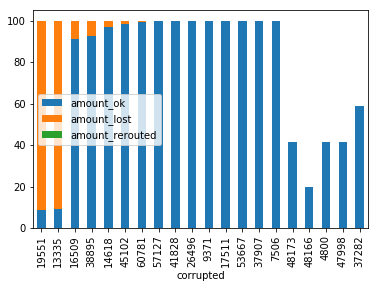

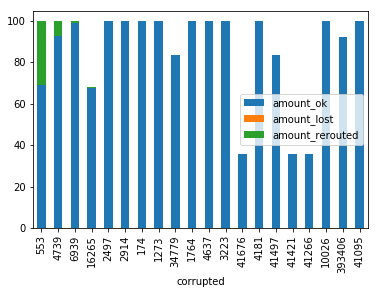

In [21]:
remove_result.sort_values(by='amount_lost',ascending=False).head(20).plot.bar(stacked=True)
remove_result.sort_values(by='amount_rerouted',ascending=False).head(20).plot.bar(stacked=True)

# What if there is BGP hijacking?

In [12]:
hijack_jan = generate_hijack_analysis(ripple_graph_jan,transactions_jan,best_paths_jan).set_index('corrupted')
hijack_feb = generate_hijack_analysis(ripple_graph_feb,transactions_feb,best_paths_feb).set_index('corrupted')
hijack_mar = generate_hijack_analysis(ripple_graph_mar,transactions_mar,best_paths_mar).set_index('corrupted')
hijack_apr = generate_hijack_analysis(ripple_graph_apr,transactions_apr,best_paths_apr).set_index('corrupted')
hijack_may = generate_hijack_analysis(ripple_graph_may,transactions_may,best_paths_may).set_index('corrupted')
hijack_jun = generate_hijack_analysis(ripple_graph_jun,transactions_jun,best_paths_jun).set_index('corrupted')
hijack_jul = generate_hijack_analysis(ripple_graph_jul,transactions_jul,best_paths_jul).set_index('corrupted')
hijack_aug = generate_hijack_analysis(ripple_graph_aug,transactions_aug,best_paths_aug).set_index('corrupted')

In [25]:
hijack_list = [hijack_jan, hijack_feb, hijack_mar, hijack_apr, hijack_may, hijack_jun, hijack_jul, hijack_aug]
hijack_result = reduce(lambda x, y: x.add(y, fill_value=0), hijack_list)

In [26]:
## Visualisation
hijack_result['amount_ok'] = hijack_result['amount_ok'].apply(lambda x: x*100/transactions['amount'].sum())
hijack_result['amount_lost'] = hijack_result['amount_lost'].apply(lambda x: x*100/transactions['amount'].sum())
hijack_result['amount_rerouted'] = hijack_result['amount_rerouted'].apply(lambda x: x*100/transactions['amount'].sum())

In [27]:
hijack_result.to_csv('statistics_hijack.csv')

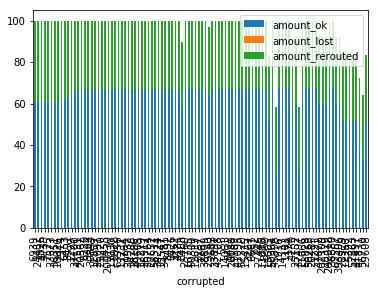

In [30]:
hijack_result.sort_values(by='amount_rerouted',ascending=False).head(100).plot.bar(stacked=True)